---
POC Synthetische data & Gemeente Amsterdam
---
---
**Achtergrond**
> De gemeente Amsterdam verzameld een groot aantal gegevens van hun burgers om de verschillende wettelijke taken uit te voeren. Deze taken richten zich onder andere op het zorgdomein (e.g., WMO, Jeugdzorg, publieke gezondheid zoals deze door de GGD wordt uitgevoerd). Doordat er verschillende zorgwetten zijn is het niet triviaal vanuit de privacy richtlijnen om persoonsgegevens vanuit verschillende zorgdomeinen binnen een persoon aan elkaar te koppelen. Hoewel er wel mogelijkheden zijn om dit te doen (e.g., microdata omgeving CBS, zicht en grip pilot vanuit de gemeente Amsterdam) zijn deze vaak omslachtig en duur.
>
> Een andere uitdaging met het werken van persoonsgegevens is dat deze, zelfs binnen een enkele wet, niet zo maar gedeeld kunnen worden met andere interne of externe onderzoekers. Om dit mogelijk te maken zal er eerst (minimaal) een Data Protection Impact Assessment (DPIA) uitgevoerd moeten worden die gevolgd wordt door een Data Sharing Agreement (DSA). Dit process is op het moment van schrijven niet optimaal waardoor projecten langzaam van start kunnen gaan en andere kleine vraagstukken überhaupt niet opgepakt worden omdat het niet de tijdsinvestering van de DPIA niet waard is.

**Een alternatief**
> Vanuit de AI en data science domeinen zijn er methodes ontwikkeld die een gebruiker instaat stelt om aan de hand van persoonsgegevens _synthetische data_ te creëren. Deze _synthetische data_ bevat alle statistische kenmerken van de waargenomen persoonsgegevens, maar elk nieuw datapunt is dus niet gebaseerd op een individu. Een van de voordelen van _synthetische data_ is dat het een aantal privacy processen mogelijk overbodig maakt waardoor het makkelijk wordt om data te combineren over wetten en te delen met interne en externe onderzoekers.

**Doel van dit notebook**
> Het doel van deze proof of concept (POC) notebook is om aan de hand van een veelgebruikt publiekelijke dataset het concept van _synthetische data_ en een aantal kwaliteitscontroles te introduceren. Om daarna het gesprek met de privacy officier te kunnen voeren of:
1) synthetische data veelbelovend is voor de gemeente Amsterdam
2) aan welke kwaliteitseisen deze synthetische data moet voldoen voordat deze vrij gedeeld zou kunnen worden


**Auteur notebook**
> Loek Berkers (l.berkers@amsterdam.nl)
> Max Keuken (mkeuken@ggd.amsterdam.nl)
---


---
## Census data importeren en beschrijven

---
> Census data van de VS afkomstig uit de UCI Machine Learning repository, opgeschoond en standaard opgekomen in het python package SDV (Synthetic Data Vault) wat in dit notebook wordt gebruikt om synthetische data te genereren. De census data bevat een enkele tabel op persoonsniveau met 41 verschillende eigenschappen van elk individu.

In [18]:
from sdv.demo import load_tabular_demo
metadata, data = load_tabular_demo("census", metadata=True)

from ydata_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")
display(profile)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
%matplotlib inline
import pandas as pd
from ydata_profiling import ProfileReport
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Model
import sdgym
from sdv.tabular import CTGAN

# Metrics
from sdmetrics.reports.single_table import DiagnosticReport
from sdmetrics.reports.single_table import QualityReport

In [2]:
import sdv
sdv.demo.get_available_demos()

,name,tables,rows,columns
0,UTube_v1,2,2735,10
1,SAP_v1,4,3841029,71
2,NCAA_v1,9,202305,333
3,airbnb-simplified,2,5751408,22
4,Atherosclerosis_v1,4,12781,307
5,rossmann,3,2035533,21
6,walmart,4,544869,24
7,AustralianFootball_v1,4,139179,193
8,Pyrimidine_v1,2,296,38
9,world_v1,3,5302,39


In [17]:
data.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000


In [26]:
dataDir = "~/Documents/GitHub/gan/data/"

# Percentage of random rows to import
# p = 0.0001
# df_sample = pd.read_csv(
#     dataDir+"COVID-19_Case_Surveillance_Public_Use_Data.csv",
#     sep=",",
#     header=0,
#     skiprows=lambda i: i>0 and random.random() > p,
#     parse_dates=[
#         "cdc_case_earliest_dt ",
#         "cdc_report_dt",
#         "pos_spec_dt",
#         "onset_dt"
#     ]
# )
df_sample = pd.read_csv(dataDir+"Subset_COVID-19_Case_Surveillance_Public_Use_Data.csv")
print("How many rows are we working with: ", df_sample.shape)
df_sample["UniqueID"] = df_sample.index

df_sample.rename(
    columns={
        "cdc_case_earliest_dt " : "cdc_case_earliest_dt"
    },
    inplace=True
)

df_sample = df_sample.sort_values(
    [
        "cdc_case_earliest_dt",
        "cdc_report_dt",
        "pos_spec_dt",
        "onset_dt",
    ]
)

# Create a dataframe without a timeseries component
df = df_sample[
    [
        "UniqueID",
        "sex",
        "age_group",
        "race_ethnicity_combined",
        "current_status",
        "hosp_yn",
        "icu_yn",
        "death_yn",
        "medcond_yn",
    ]
]

df.to_csv(dataDir+"GANs_POC_MHS_Amsterdam_sample.csv")

# Create a dataframe with a single timeseries
df_timeserie = df_sample[
    [
        "UniqueID",
        "sex",
        "age_group",
        "race_ethnicity_combined",
        "cdc_report_dt",
        "current_status",
        "hosp_yn",
        "icu_yn",
        "death_yn",
        "medcond_yn",
    ]
]

df_timeserie["cdc_report_dt"] = pd.to_datetime(df_timeserie["cdc_report_dt"])

df_timeserie.to_csv(dataDir+"GANs_POC_MHS_Amsterdam_sample_timeserie.csv")


How many rows are we working with:  (94030, 13)


### Data description

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## GAN

### Metadata

In [27]:
metadata_df = {
    'fields': {
        "UniqueID": {'type': 'id', 'subtype': 'integer'},
        "sex": {'type': 'categorical'},
        "age_group": {'type': 'categorical'},
        "race_ethnicity_combined": {'type': 'categorical'},
        "current_status": {'type': 'categorical'},
        "hosp_yn": {'type': 'categorical'},
        "icu_yn": {'type': 'categorical'},
        "death_yn": {'type': 'categorical'},
        "medcond_yn": {'type': 'categorical'}
    },
    'constraints': [],
    'primary_key': "UniqueID"
}

metadata_df_timeseries = {
    'fields': {
        "UniqueID": {'type': 'id', 'subtype': 'integer'},
        "sex": {'type': 'categorical'},
        "age_group": {'type': 'categorical'},
        "race_ethnicity_combined": {'type': 'categorical'},
        "cdc_report_dt": {"type": "datetime", "format": "%Y-%m-%d"},
        "current_status": {'type': 'categorical'},
        "hosp_yn": {'type': 'categorical'},
        "icu_yn": {'type': 'categorical'},
        "death_yn": {'type': 'categorical'},
        "medcond_yn": {'type': 'categorical'}
    },
    'constraints': [],
    'primary_key': "UniqueID"
}

## Single table

### What is the most promising model type?

In [12]:
# sdgym
sdgym.benchmark_single_table(
    sdv_datasets=["adult"],
)

/Users/mckitchen/Documents/GitHub/gan/venv/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
/Users/mckitchen/Documents/GitHub/gan/venv/lib/python3.9/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
/Users/mckitchen/Documents/GitHub/gan/venv/lib/python3.9/site-packages/sdv/lite/tabular.py:116: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, column_data in data.iteritems():


,Synthesizer,Dataset,Dataset_Size_MB,Train_Time,Peak_Memory_MB,Synthesizer_Size_MB,Sample_Time,Evaluate_Time,Quality_Score,NewRowSynthesis
0,GaussianCopulaSynthesizer,adult,3.907448,1.307400,44.757575,0.151074,0.906098,11.891581,0.830411,1.0
1,FastMLPreset,adult,3.907448,0.902997,44.584492,0.157097,0.854338,11.722400,0.822301,1.0
2,CTGANSynthesizer,adult,3.907448,839.663508,177.228776,44.590868,1.852158,10.872249,0.880739,1.0


### CTGan


#### Model definitions and fitting

In [13]:
model_ctgan = CTGAN(
    table_metadata=metadata_df,
    cuda=False
)
model_ctgan.fit(df)

/Users/mckitchen/Documents/GitHub/gan/venv/lib/python3.9/site-packages/rdt/transformers/categorical.py:381: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  warnings.warn(


#### Generate synth data

### Diagnostic and Quality reports
    SDV has two standard reports that you can create to determine how well the model
    was able to generate synthetic data. Beyond these standard summary reports you can
    generate a number of different visuals that will help evaluate the results in more
    detail.

In [14]:
synth_data_ctgan = model_ctgan.sample(num_rows=1000)

Creating report: 100%|██████████| 4/4 [00:15<00:00,  3.76s/it]
/Users/mckitchen/Documents/GitHub/gan/venv/lib/python3.9/site-packages/sdmetrics/reports/single_table/diagnostic_report.py:211: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.




DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data

DANGER:
x More than 50% of the synthetic rows are copies of the real data


Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Overall Quality Score: 87.08%

Properties:
Column Shapes: 89.79%
Column Pair Trends: 84.37%


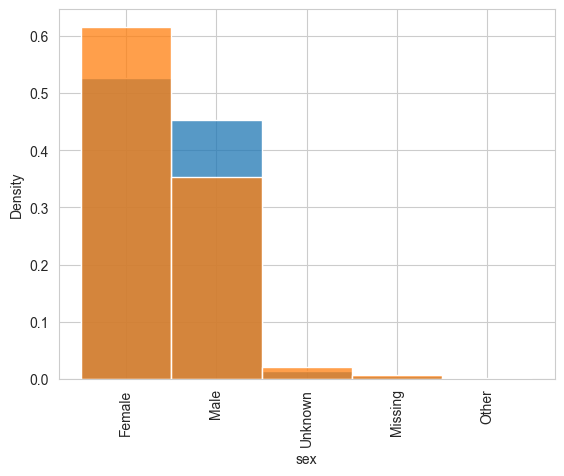

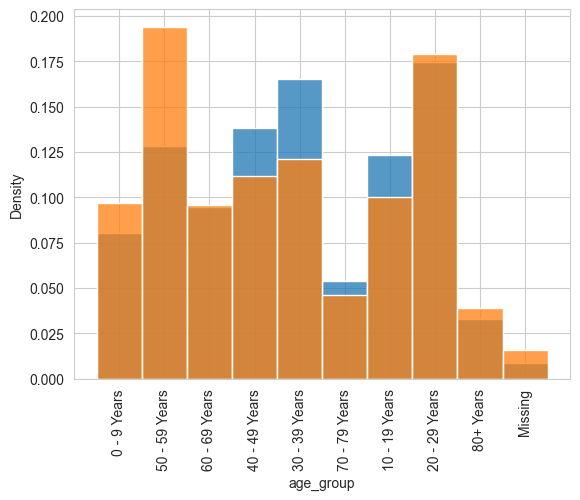

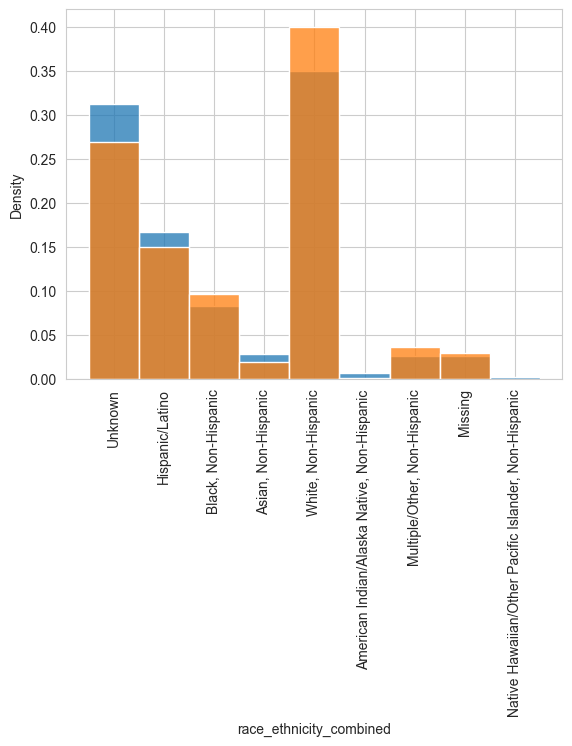

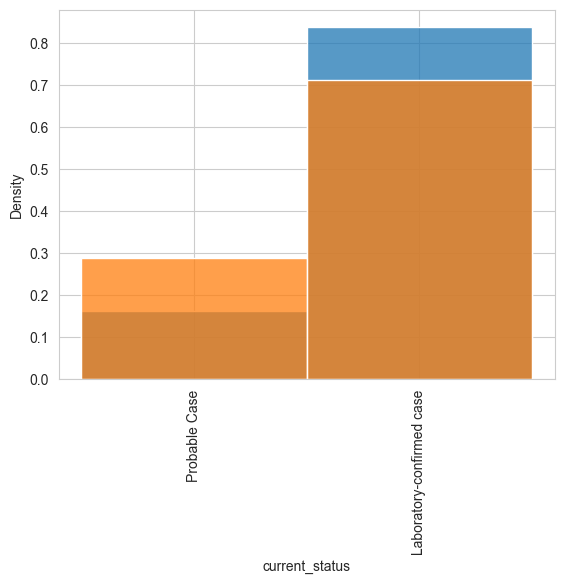

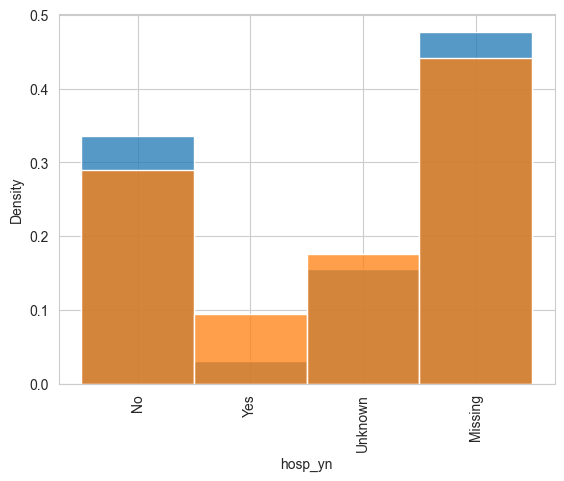

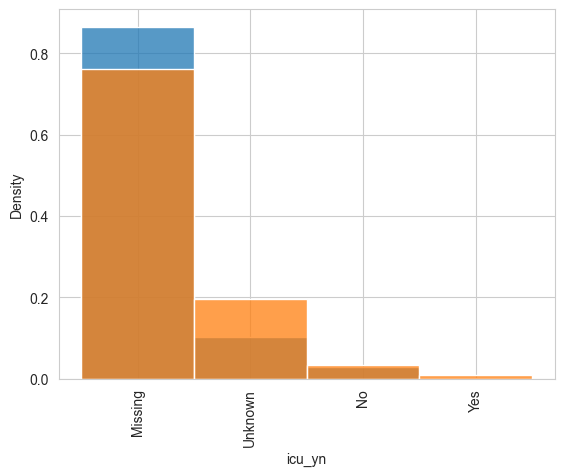

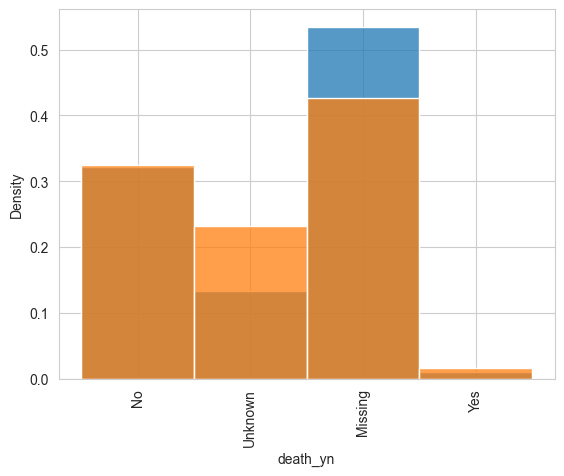

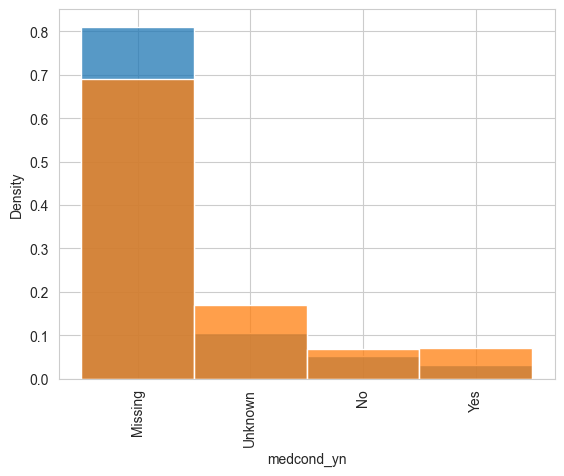

In [17]:
# Standard diagnostic report
report_diagnostic = DiagnosticReport()
report_diagnostic.generate(df, synth_data_ctgan, metadata_df)

# Standard quality report
report_quality = QualityReport()
report_quality.generate(df, synth_data_ctgan, metadata_df)

# Synthesis
# How many synthetic rows are exact matches with the real data?
fig = report_diagnostic.get_visualization(property_name='Synthesis')
fig.show()

# Trends between pairs of columns
# If both columns are numerical, the similarity is based on a simple correlation
# If both columns are categorical, the similarity is based on a contingency table
# If there is a mixture, the numerical column is cut into histogram bins and then
#  a contingency table is created.

# The first visualization are all the column pairs between real and synthetic data
# The second visualization are the numerical columns within the real and synthetic
# data.
fig = report_quality.get_visualization(property_name='Column Pair Trends')
fig.show()

# Custom figures
for column in df.select_dtypes(include=["object"]).columns:
    g = sns.histplot(df[column], stat="density")
    g = sns.histplot(synth_data_ctgan[column], stat="density")
    plt.xticks(rotation=90)
    plt.show()

## Time series

### Probabilistic AutoRegressive model (PAR)

#### Model definition and fitting

In [29]:
model_par = PAR(
    table_metadata=metadata_df_timeseries,
    segment_size=250,
    cuda=False,
    verbose=True
)
model_par.fit(df_timeserie)

Epoch 128 | Loss 0.5516803860664368: 100%|██████████| 128/128 [07:23<00:00,  3.47s/it]


#### Generate synth data

In [30]:
synth_data_par = model_par.sample(1)

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


### Diagnostic and Quality reports
    SDV has two standard reports that you can create to determine how well the model
    was able to generate synthetic data. Beyond these standard summary reports you can
    generate a number of different visuals that will help evaluate the results in more
    detail.

Creating report: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]



DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data

DANGER:
x More than 50% of the synthetic rows are copies of the real data


Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]



Overall Quality Score: 84.73%

Properties:
Column Shapes: 85.42%
Column Pair Trends: 84.03%


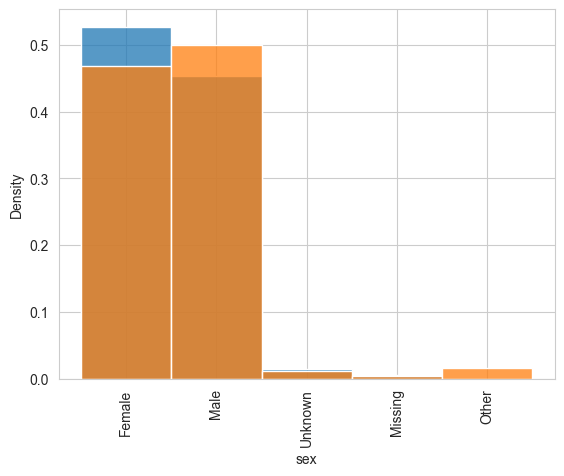

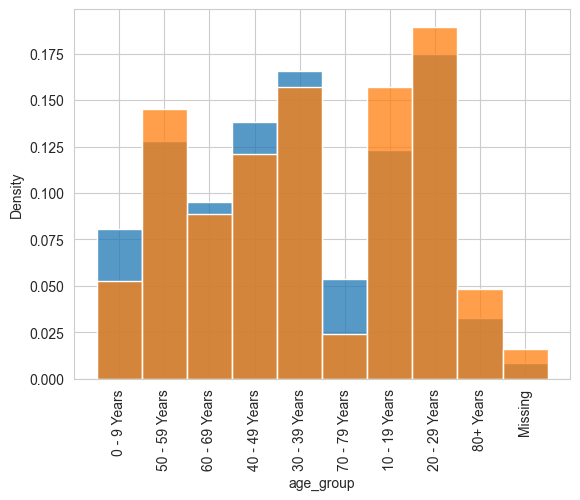

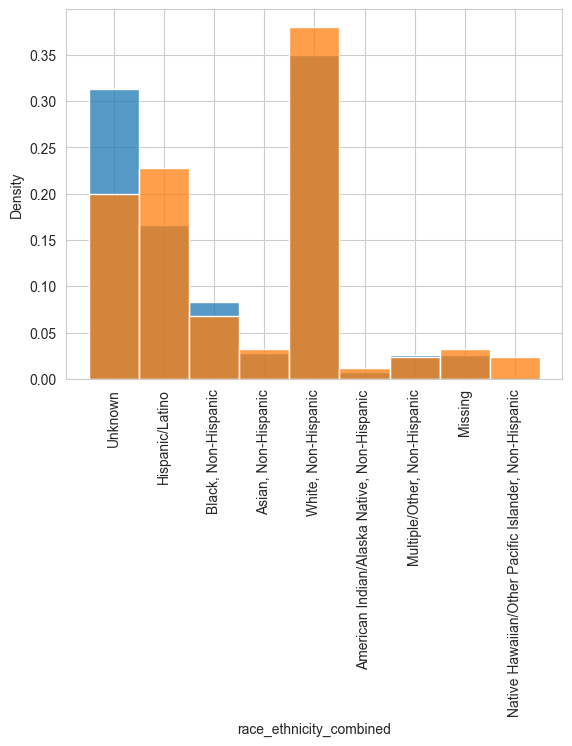

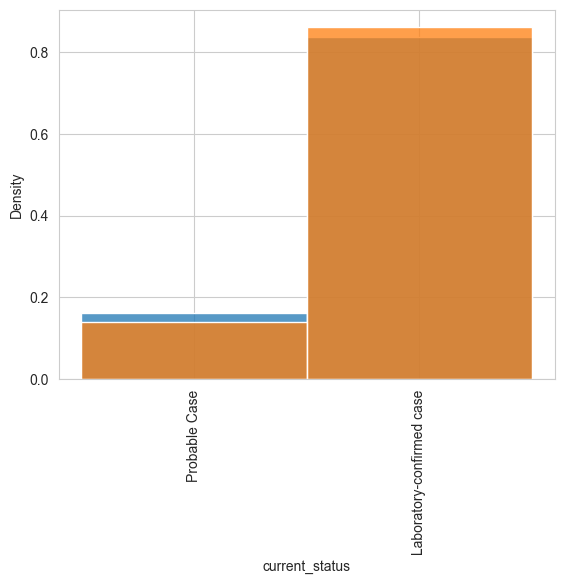

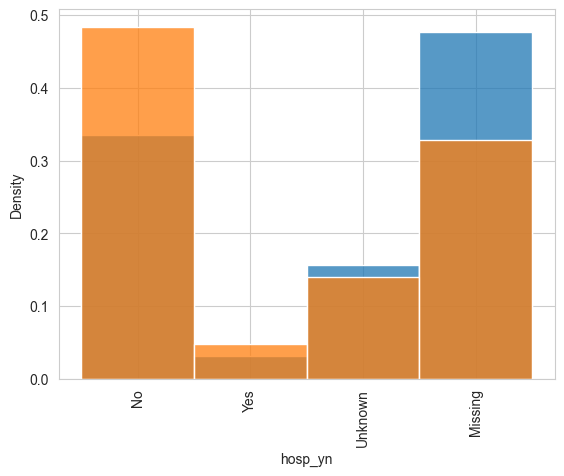

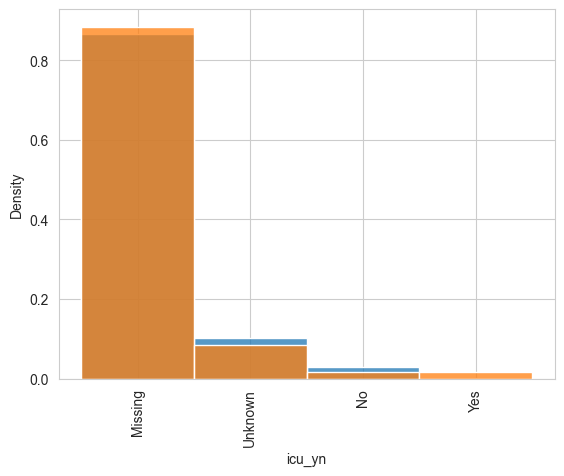

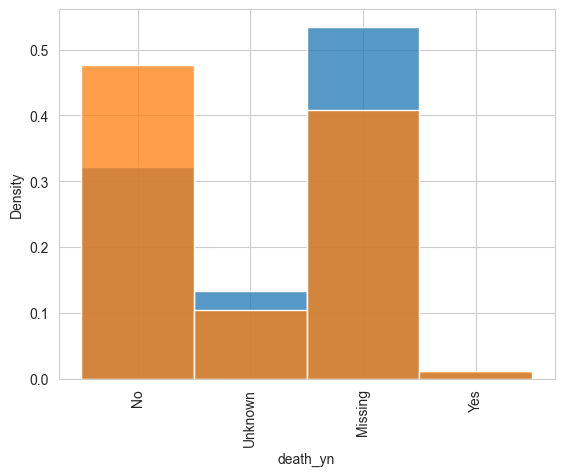

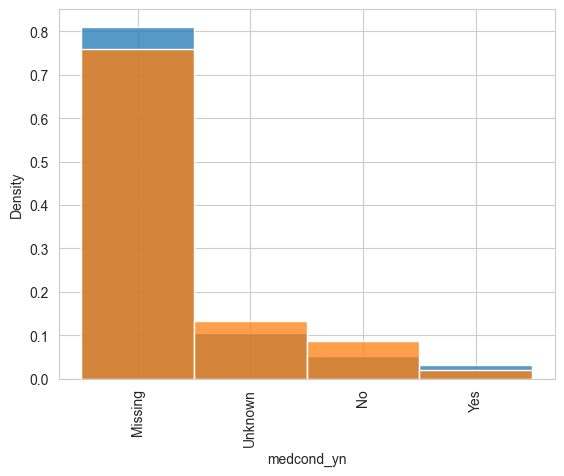

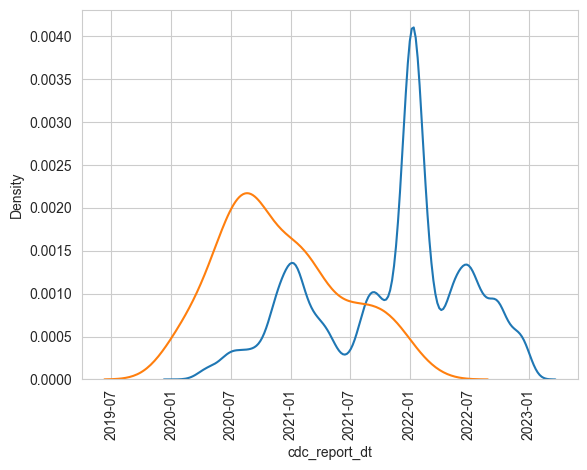

In [34]:
# Standard diagnostic report
report_diagnostic = DiagnosticReport()
report_diagnostic.generate(df_timeserie, synth_data_par, metadata_df_timeseries)

# Standard quality report
report_quality = QualityReport()
report_quality.generate(df_timeserie, synth_data_par, metadata_df_timeseries)

# Synthesis
# How many synthetic rows are exact matches with the real data?
fig = report_diagnostic.get_visualization(property_name='Synthesis')
fig.show()

# Coverage
# This metric measures whether a synthetic column covers all the possible categories
# that are present in a real column. It only says something about the range, not about
# the actual distribution (so undersampling might still happen). If certain combinations
# are very rare you might get low scores here which can be solved by creating more samples
fig = report_diagnostic.get_visualization(property_name='Coverage')
fig.show()

# Trends between pairs of columns
# If both columns are numerical, the similarity is based on a simple correlation
# If both columns are categorical, the similarity is based on a contingency table
# If there is a mixture, the numerical column is cut into histogram bins and then
#  a contingency table is created.

# The first visualization are all the column pairs between real and synthetic data
# The second visualization are the numerical columns within the real and synthetic
# data.
fig = report_quality.get_visualization(property_name='Column Pair Trends')
fig.show()

# Custom visuals
for column in df_timeserie.select_dtypes(include=["object"]).columns:
    g = sns.histplot(df_timeserie[column], stat="density")
    g = sns.histplot(synth_data_par[column], stat="density")
    plt.xticks(rotation=90)
    plt.show()
for column in df_timeserie.select_dtypes(include=["datetime64[ns]"]).columns:
    g = sns.kdeplot(df_timeserie[column])
    g = sns.kdeplot(synth_data_par[column])
    plt.xticks(rotation=90)
    plt.show()
